In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering

In [2]:
user, item, title = 'userId', 'movieId', 'title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/movie_lens_sample')

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/movie_lens_sample/ratings.csv')]

In [5]:
ratings = pd.read_csv(path/'ratings.csv')

In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [7]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [8]:
y_range = [0, 5.5]

In [9]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


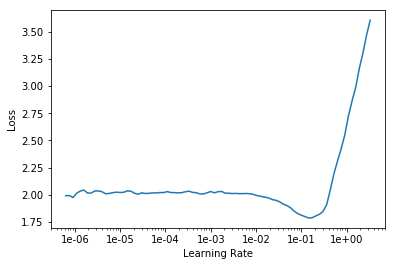

In [11]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.594524,0.956301,00:00
1,0.848203,0.672606,00:00
2,0.661477,0.669411,00:00


## Movielens 100k

In [19]:
Config.data_path()

PosixPath('/home/jupyter/.fastai/data')

In [20]:
path = Config.data_path()/'ml-100k'

In [21]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, 
                     names=[user, item, 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [24]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None, 
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
len(ratings)

100000

In [26]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [27]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [28]:
data.show_batch()

userId,title,target
788,True Lies (1994),3.0
490,Hercules (1997),1.0
454,Quiz Show (1994),4.0
399,Rudy (1993),3.0
544,Titanic (1997),5.0


In [29]:
y_range = [0, 5.5]

In [30]:
learn = collab_learner(data, n_factors=40, y_range=y_range)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


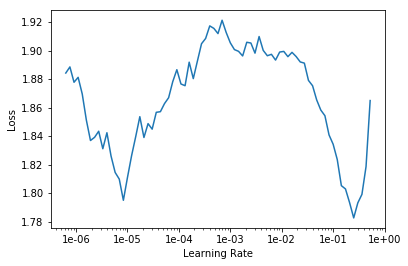

In [31]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [33]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.901824,0.928286,00:10
1,0.829763,0.865228,00:10
2,0.668032,0.851276,00:10
3,0.482539,0.866102,00:11
4,0.369285,0.873725,00:10


In [34]:
learn.save('dotprod')

## Interpretation

In [35]:
learn.load('dotprod')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
userId 196; title Kolya (1996); ,userId 63; title Kolya (1996); ,userId 226; title Kolya (1996); ,userId 154; title Kolya (1996); ,userId 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
userId 498; title Casino (1995); ,userId 642; title Pocahontas (1995); ,userId 58; title 2001: A Space Odyssey (1968); ,userId 495; title Cat People (1982); ,userId 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<cla

In [36]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [37]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

## Movie bias

In [38]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [40]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i, b in zip(top_movies, movie_bias)]

In [41]:
item0 = lambda o:o[0]

In [42]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.5323),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.4543), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.4518),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.3983), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.3794), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.3689), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.3549), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.3517), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.3470), 'Grease 2 (1982)', 2.0),
 (tensor(-0.3449), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.3397), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.3336), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.3299), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.3283), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.3264), 'Beverly Hills Ninja (1997)', 2.

In [44]:
sorted(movie_ratings, key=item0, reverse=True)[:15]

[(tensor(0.8186), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.8158), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.7551), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.7166), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.7155), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.7124), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.7012), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.6950), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.6919), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.6769), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.6628), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.6608), 'Apt Pupil (1998)', 4.1),
 (tensor(0.6298), 'Henry V (1989)', 4.137096774193548),
 (tensor(0.6289), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.6215), 'Usual Suspects, The (1995)', 4.385767790262173)]

## Movie weight

In [45]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [46]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [47]:
fac0, fac1, fac2 = movie_pca.t()
movie_comp = [(f, i) for f, i in zip(fac0, top_movies)]

In [49]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.4800), 'Congo (1995)'),
 (tensor(1.4009), 'D3: The Mighty Ducks (1996)'),
 (tensor(1.3357), 'Home Alone 3 (1997)'),
 (tensor(1.3214), 'Mr. Wrong (1996)'),
 (tensor(1.3210), 'Free Willy 3: The Rescue (1997)'),
 (tensor(1.3135), 'Road to Wellville, The (1994)'),
 (tensor(1.2999), "McHale's Navy (1997)"),
 (tensor(1.2946), 'Bio-Dome (1996)'),
 (tensor(1.2476), 'Jungle2Jungle (1997)'),
 (tensor(1.2291), 'Flipper (1996)')]

In [50]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2491), 'When We Were Kings (1996)'),
 (tensor(-1.2399), 'Wrong Trousers, The (1993)'),
 (tensor(-1.2175), 'Ran (1985)'),
 (tensor(-1.2103), 'Chinatown (1974)'),
 (tensor(-1.1786), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(-1.1670), 'Persuasion (1995)'),
 (tensor(-1.1645), 'Close Shave, A (1995)'),
 (tensor(-1.1397), 'Lawrence of Arabia (1962)'),
 (tensor(-1.1172), 'Trust (1990)'),
 (tensor(-1.0791), 'Third Man, The (1949)')]

In [51]:
movie_comp = [(f, i) for f, i in zip(fac1, top_movies)]

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1759), 'Keys to Tulsa (1997)'),
 (tensor(1.0922), 'Lost Highway (1997)'),
 (tensor(1.0604), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(1.0307), 'Beavis and Butt-head Do America (1996)'),
 (tensor(1.0288), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(1.0177), 'Road to Wellville, The (1994)'),
 (tensor(1.0007), 'Cable Guy, The (1996)'),
 (tensor(0.9582), 'Serial Mom (1994)'),
 (tensor(0.9526), 'Crow: City of Angels, The (1996)'),
 (tensor(0.9510), 'Trainspotting (1996)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.3012), 'Braveheart (1995)'),
 (tensor(-1.2645), 'Affair to Remember, An (1957)'),
 (tensor(-1.1564), "It's a Wonderful Life (1946)"),
 (tensor(-1.0845), 'Forrest Gump (1994)'),
 (tensor(-1.0348), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0225), 'Higher Learning (1995)'),
 (tensor(-1.0103), 'Field of Dreams (1989)'),
 (tensor(-0.9877), 'Selena (1997)'),
 (tensor(-0.9746), 'American President, The (1995)'),
 (tensor(-0.9457), 'Titanic (1997)')]

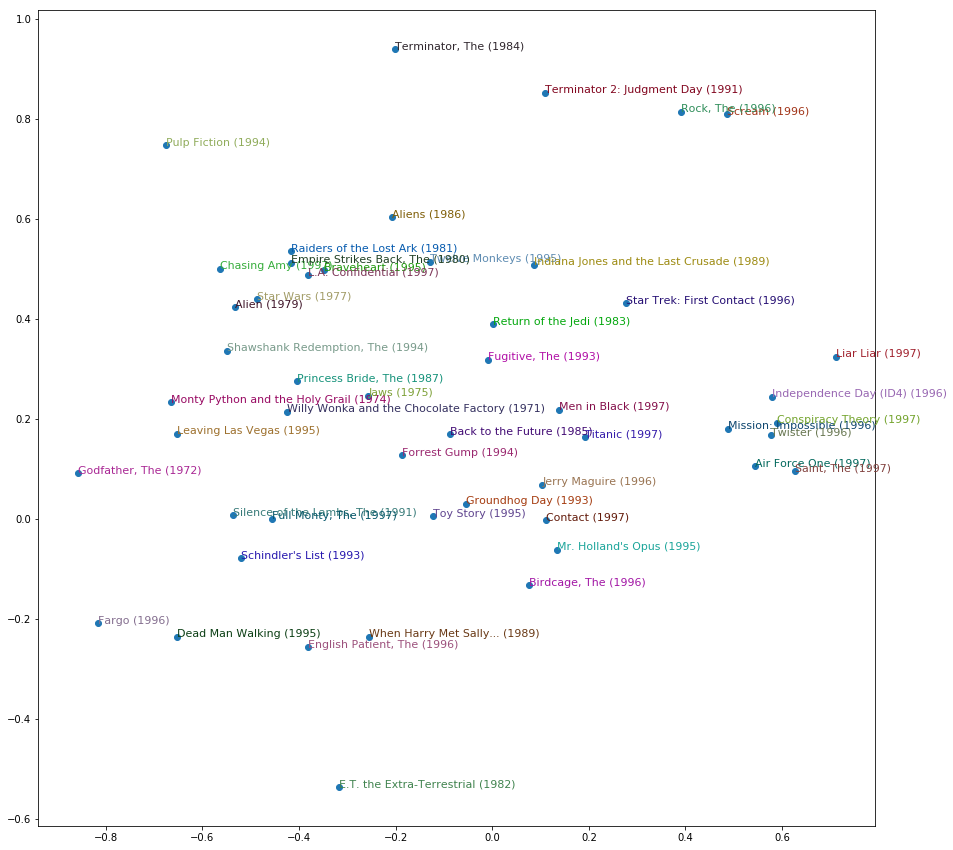

In [57]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15, 15))
plt.scatter(X, Y)

for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3)*0.7, fontsize=11)

plt.show()